<a href="https://colab.research.google.com/github/dcolinmorgan/AXA_AE_app/blob/main/axa_ae_cd9loc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


(2555, 7, 8) (2555, 1) (3648, 7, 8) (3648, 1)


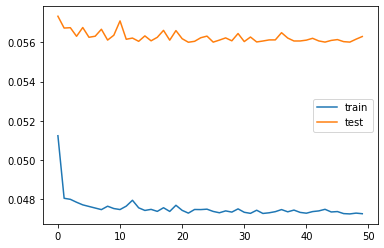

In [4]:

# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# data=pd.read_parquet('/content/drive/MyDrive/hku/AXA/AE_AXA_poll-ae.parquet')#, compression='GZIP')#.mode('overwrite')
# data=data[data['cd9_loc']=='Queen Elizabeth Hospital']
# site='QEH'
# data=data.groupby(['cd9_loc','date']).agg('mean')[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
# data=data.groupby(['date']).agg('mean')[['pm25','pm10','o3','no2','so2','co','diag1']]
# data=data[['pm25','pm10','o3','no2','so2','co','age','sex','diag1']]
# data=data.groupby(['ds']).agg({'pm25':'mean','pm10':'mean','o3':'mean','no2':'mean','so2':'mean','co':'mean','age':'mean','sex':'mean','diag1':'mean'})

data=pd.read_parquet('/content/drive/MyDrive/hku/AXA/AE_AXA_poll-ae.parquet')#, compression='GZIP')#.mode('overwrite')
aa=data['date']
data=data.groupby(['ds']).agg({'pm25':'mean','pm10':'mean','o3':'mean','no2':'mean','so2':'mean','co':'mean','age':'mean','sex':'mean','diag1':'mean'})
data.index=aa

data.age=np.round(data.age)
data.sex=np.round(data.sex)
# first_column = data.pop('diag1') ## comment for avg all loc
# data.insert(0, 'diag1', first_column) ## comment for avg all loc

dataset=data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

x_scaled = scaled[:,:data.shape[1]-1].astype('float32') #.drop('diag1',axis=1).values.astype('float32')
y_scaled = scaled[:,data.shape[1]-1:].astype('float32') #['diag1'].values.astype('float32')
# integer encode direction
encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
# values = values.astype('float32')
# normalize features


# y_scaled = scaler.fit_transform(y_values)

# specify the number of lag days
n_days = 7
n_features =  x_scaled.shape[1]
# frame as supervised learning

x_reframed = series_to_supervised(x_scaled, n_days, 1).values
y_reframed = y_scaled #series_to_supervised(y_scaled, n_days, 1).values
y_reframed = y_reframed[:x_reframed.shape[0]]
# print(reframed.shape)

# drop=np.arange(n_features+1,(2*n_features),1)
# reframed.drop(reframed.columns[drop], axis=1, inplace=True)


# split into train and test sets
# values = reframed.values

n_train_days = 365 * 7 #round((len(x_scaled)/365)*.5) #* 24
n_obs = n_days * n_features
train_X = x_reframed[:n_train_days, :]
test_X = x_reframed[n_train_days:, :]

train_y = y_reframed[:n_train_days]
test_y = y_reframed[n_train_days:]

# split into input and outputs

train_X = train_X[:, :n_obs]#, train_y[:n_obs]
test_X = test_X[:, :n_obs]#, test_y[:n_obs]

# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# # design network
model = Sequential()
model.add(LSTM(96, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
# model.add(LSTM(180, activation='relu',return_sequences=True))
# model.add(LSTM(96, activation='relu',return_sequences=True))
model.add(LSTM(48, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [5]:
# make a prediction
yhat = model.predict(test_X)

[(3648,), (3648,), (3648,)]
Test MSE: 719.436


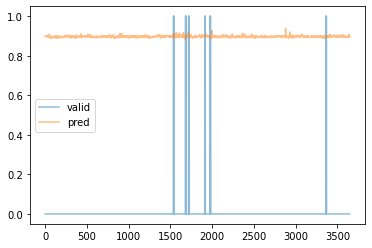

In [6]:
test_X2 = test_X.reshape((test_X.shape[0], n_days*n_features))
# # invert scaling for forecast
inv_yhat = concatenate((yhat, test_X2[:, -(n_features):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual


test_y2 = test_y.reshape(test_y.shape[0]*test_y.shape[1])
inv_y = concatenate((test_y, test_X2[:, -(n_features):]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

print([inv_yhat.shape,test_y2.shape,inv_y.shape])


# calculate MSE
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)

plt.plot(np.rint(inv_y), alpha = .5,label='valid')
plt.plot(np.double(inv_yhat)/30, alpha = .5,label='pred')
# plt.title(site+'_'+var+'_'+YY+ 'MSE: '+str(mse))
plt.legend()
# # plt.savefig('NNtest/'+site+'_'+var+'_'+YY+'_mse.png')
# plt.clf()

